# Prerequisites

## Install Library

In [2]:
# for python 3.11.4
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import Library

In [3]:
## Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.automl import H2OAutoML
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, average_precision_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
import json
import joblib
import warnings
warnings.filterwarnings("ignore")

## Read Data

In [4]:
df = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTrain_cleaned.csv", index_col=0)
# df = pd.read_csv("D:/NIDA/9000_IS/dataset/fraudTrain_cleaned.csv", index_col=0)

In [5]:
# Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [6]:
df.head()

,trans_date_trans_time,cc_num,merchant,amt,first,last,gender,street,city,state,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,distance
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,514,4.97,Jennifer,Banks,0,561 Perry Cove,526,27,...,0,0,0,1,0,0,0,0,0,78.773821
1,2019-01-01 00:00:44,630423337322,241,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,612,47,...,0,0,0,0,0,0,0,0,0,30.216618
2,2019-01-01 00:00:51,38859492057661,390,220.11,Edward,Sanchez,1,594 White Dale Suite 530,468,13,...,0,0,0,0,0,0,0,0,0,108.102912
3,2019-01-01 00:01:16,3534093764340240,360,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,84,26,...,0,0,0,0,0,0,0,0,0,95.685115
4,2019-01-01 00:03:06,375534208663984,297,41.96,Tyler,Garcia,1,408 Bradley Rest,216,45,...,0,0,0,0,1,0,0,0,0,77.702395


In [7]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud', 'age', 'hour', 'day', 'month', 'year', 'is_weekend',
       'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes',
       'diff_seconds', 'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'distance'],
      dtype='object')

In [8]:
df.dtypes

trans_date_trans_time      datetime64[ns]
cc_num                              int64
merchant                            int64
amt                               float64
first                              object
last                               object
gender                              int64
street                             object
city                                int64
state                               int64
zip                                 int64
lat                               float64
long                              float64
city_pop                            int64
job                                 int64
dob                                object
trans_num                          object
unix_time                           int64
merch_lat                         float64
merch_long                        float64
is_fraud                            int64
age                                 int64
hour                                int64
day                               

In [9]:
df.isnull().sum()

trans_date_trans_time      0
cc_num                     0
merchant                   0
amt                        0
first                      0
last                       0
gender                     0
street                     0
city                       0
state                      0
zip                        0
lat                        0
long                       0
city_pop                   0
job                        0
dob                        0
trans_num                  0
unix_time                  0
merch_lat                  0
merch_long                 0
is_fraud                   0
age                        0
hour                       0
day                        0
month                      0
year                       0
is_weekend                 0
is_weekday                 0
time_diff                  0
diff_days                  0
diff_hours                 0
diff_minutes               0
diff_seconds               0
category_entertainment     0
category_food_

In [10]:
df_all = df.copy()

# Standard 70/20/10 train/validation/test split
# First split: 70% train, 30% temp (ซึ่งจะถูกแบ่งเป็น 20% val, 10% test)
X_temp = df_all.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud'], axis=1)
y_temp = df_all['is_fraud']

X_train, X_temp, y_train, y_temp = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

# Second split: 20% validation, 10% test (จาก 30% temp)
# 20/30 = 0.667 สำหรับ validation, 10/30 = 0.333 สำหรับ test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp
)

# สร้าง DataFrame สำหรับแต่ละชุดข้อมูล
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

df_train_final = df_all.loc[train_indices]
df_val = df_all.loc[val_indices]
df_test = df_all.loc[test_indices]

# Remove unnecessary columns
columns_to_exclude = ['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num']

for col in columns_to_exclude:
    if col in df_train_final.columns:
        df_train_final = df_train_final.drop(col, axis=1)
    if col in df_val.columns:
        df_val = df_val.drop(col, axis=1)
    if col in df_test.columns:
        df_test = df_test.drop(col, axis=1)

print(f"Training set shape: {df_train_final.shape}")
print(f"Validation set shape: {df_val.shape}")
print(f"Test set shape: {df_test.shape}")

Training set shape: (907672, 42)
Validation set shape: (259465, 42)
Test set shape: (129538, 42)


In [11]:
df_train_final.shape, df_val.shape, df_test.shape

((907672, 42), (259465, 42), (129538, 42))

# Model Pipeline

## H2O AutoML

### Set up

In [12]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,58 mins 56 secs
H2O_cluster_timezone:,Asia/Bangkok
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 26 days
H2O_cluster_name:,H2O_from_python_thanyalak_tbgcyc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.232 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [13]:
# Convert pandas DataFrame to H2O Frame
train_h2o = h2o.H2OFrame(df_train_final)
val_h2o = h2o.H2OFrame(df_val)
test_h2o = h2o.H2OFrame(df_test)

# Define target variable and features (no column exclusion needed since already removed)
target = 'is_fraud'
features = [col for col in train_h2o.columns if col != target]

# Convert target column to categorical (factor) in H2OFrame
train_h2o[target] = train_h2o[target].asfactor()
val_h2o[target] = val_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

print(f"Features used: {features}")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Features used: ['cc_num', 'merchant', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'age', 'hour', 'day', 'month', 'year', 'is_weekend', 'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes', 'diff_seconds', 'category_entertainment', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'distance']


In [14]:
# Call H2O AutoML with optimized settings for faster execution
aml = H2OAutoML(
    max_runtime_secs=600,
    seed=42,
    balance_classes=True,
    stopping_metric="AUCPR",
    sort_metric="AUCPR",
)

aml.train(x=features, y=target, training_frame=train_h2o, validation_frame=val_h2o)

print("✅ H2O AutoML training completed!")

AutoML progress: |

███████████████████████████████████████████████████████████████| (done) 100%
✅ H2O AutoML training completed!


In [15]:
aml.leaderboard

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_3_20250723_224302,0.94156,0.998809,0.00418267,0.078388,0.0316569,0.00100216
GBM_1_AutoML_3_20250723_224302,0.93921,0.997774,0.00959413,0.0800757,0.0466279,0.00217416
XGBoost_1_AutoML_3_20250723_224302,0.933612,0.998312,0.00618443,0.0731296,0.0390001,0.00152101
XGBoost_2_AutoML_3_20250723_224302,0.570788,0.988962,0.454875,0.300158,0.366024,0.133973
DRF_1_AutoML_3_20250723_224302,0.540933,0.884013,0.0735925,0.206661,0.0576246,0.0033206
GBM_3_AutoML_3_20250723_224302,0.523618,0.97699,0.0337323,0.28081,0.0757215,0.00573374
GLM_1_AutoML_3_20250723_224302,0.209058,0.846702,0.0323441,0.303102,0.0761802,0.00580342
GBM_2_AutoML_3_20250723_224302,0.103176,0.883991,0.0345013,0.315546,0.0757801,0.00574262
GBM_4_AutoML_3_20250723_224302,0.036102,0.726449,0.0350251,0.421147,0.07582,0.00574867


In [16]:
aml.leader

key,value
Stacking strategy,blending
Number of base models (used / total),2/3
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [17]:
# Predict on test set
leader = aml.leader
preds = aml.leader.predict(test_h2o).as_data_frame()
y_true = test_h2o['is_fraud'].as_data_frame().values.flatten().astype(int)
y_pred = preds['predict'].values.astype(int)
y_score = preds['p1'].values

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


In [18]:
aml.leaderboard.as_data_frame()

,model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
0,StackedEnsemble_BestOfFamily_1_AutoML_3_202507...,0.941560,0.998809,0.004183,0.078388,0.031657,0.001002
1,GBM_1_AutoML_3_20250723_224302,0.939210,0.997774,0.009594,0.080076,0.046628,0.002174
2,XGBoost_1_AutoML_3_20250723_224302,0.933612,0.998312,0.006184,0.073130,0.039000,0.001521
3,XGBoost_2_AutoML_3_20250723_224302,0.570788,0.988962,0.454875,0.300158,0.366024,0.133973
4,DRF_1_AutoML_3_20250723_224302,0.540933,0.884013,0.073592,0.206661,0.057625,0.003321
5,GBM_3_AutoML_3_20250723_224302,0.523618,0.976990,0.033732,0.280810,0.075721,0.005734
6,GLM_1_AutoML_3_20250723_224302,0.209058,0.846702,0.032344,0.303102,0.076180,0.005803
7,GBM_2_AutoML_3_20250723_224302,0.103176,0.883991,0.034501,0.315546,0.075780,0.005743
8,GBM_4_AutoML_3_20250723_224302,0.036102,0.726449,0.035025,0.421147,0.075820,0.005749


### 2.2 Evaluate and Compare The Results

Classification Report

In [19]:
# Evaluate on test set
y_true = test_h2o['is_fraud'].as_data_frame().values.flatten().astype(int)
y_pred = preds['predict'].values.astype(int)
y_score = preds['p1'].values
print(classification_report(y_true, y_pred))
print('ROC-AUC:', roc_auc_score(y_true, y_score))
print('PR-AUC:', average_precision_score(y_true, y_score))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128788
           1       0.94      0.85      0.89       750

    accuracy                           1.00    129538
   macro avg       0.97      0.92      0.95    129538
weighted avg       1.00      1.00      1.00    129538

ROC-AUC: 0.9981757410110673
PR-AUC: 0.9414956352682714


Confusion Matrix

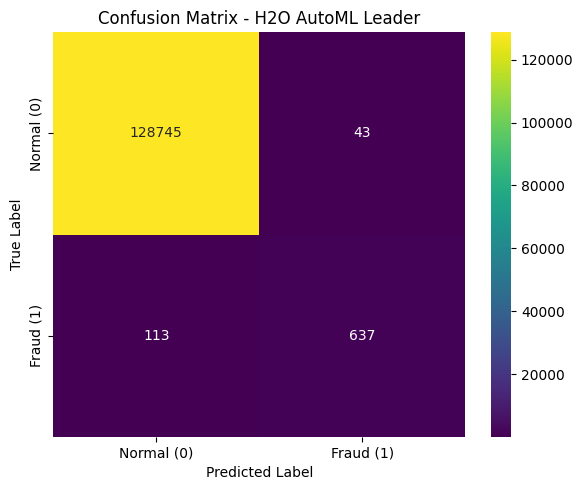

In [20]:
# Predicted values and true values for confusion matrix for Optuna (Bayesian Optimization)
cm = confusion_matrix(y_true, y_pred)
labels = ['Normal (0)', 'Fraud (1)']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - H2O AutoML Leader')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [21]:
metrics_h2o = {
    "Method": ["H2O AutoML"],
    "Precision": [precision_score(y_true, y_pred)],
    "Recall": [recall_score(y_true, y_pred)],
    "F1-Score": [f1_score(y_true, y_pred)],
    "ROC-AUC": [roc_auc_score(y_true, y_score)],
    "PR-AUC": [average_precision_score(y_true, y_score)],
    "Cohen Kappa": [cohen_kappa_score(y_true, y_pred)]
}

df_metrics_h2o = pd.DataFrame(metrics_h2o)
display(df_metrics_h2o)

,Method,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Cohen Kappa
0,H2O AutoML,0.936765,0.849333,0.890909,0.998176,0.941496,0.890305


ROC Curve

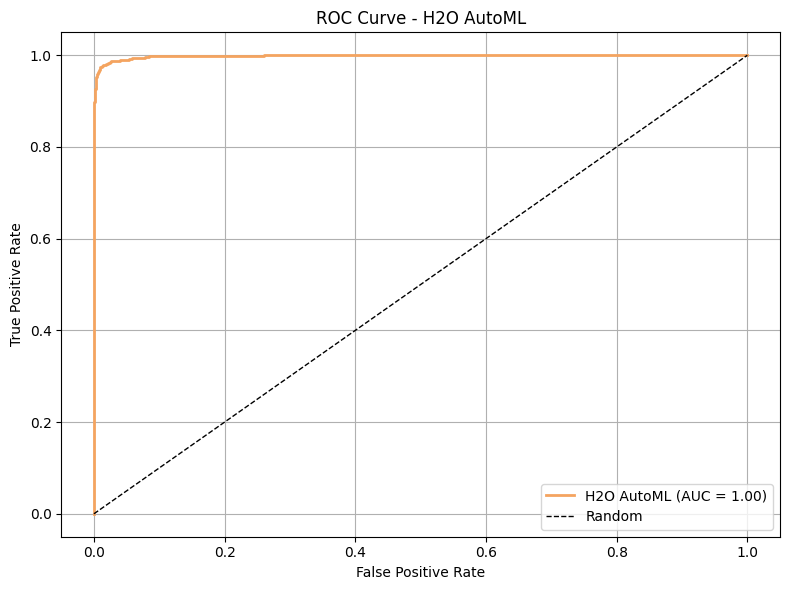

In [22]:
# --- Display ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='sandybrown', lw=2, label=f'H2O AutoML (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - H2O AutoML')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Precision-Recall Curve

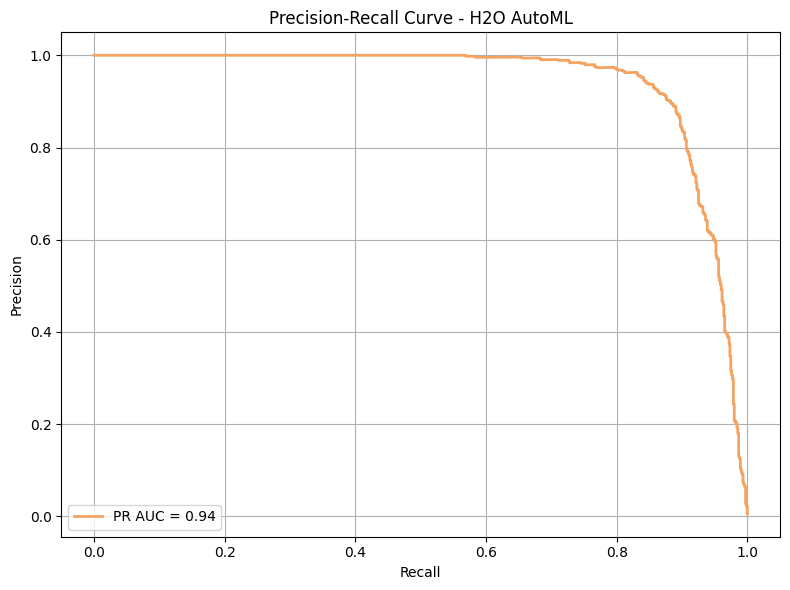

In [23]:
# --- Display Precision-Recall Curve ---
precision, recall, thresholds = precision_recall_curve(y_true, y_score)
pr_auc = average_precision_score(y_true, y_score)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='sandybrown', lw=2, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - H2O AutoML')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

Metrics Comparison

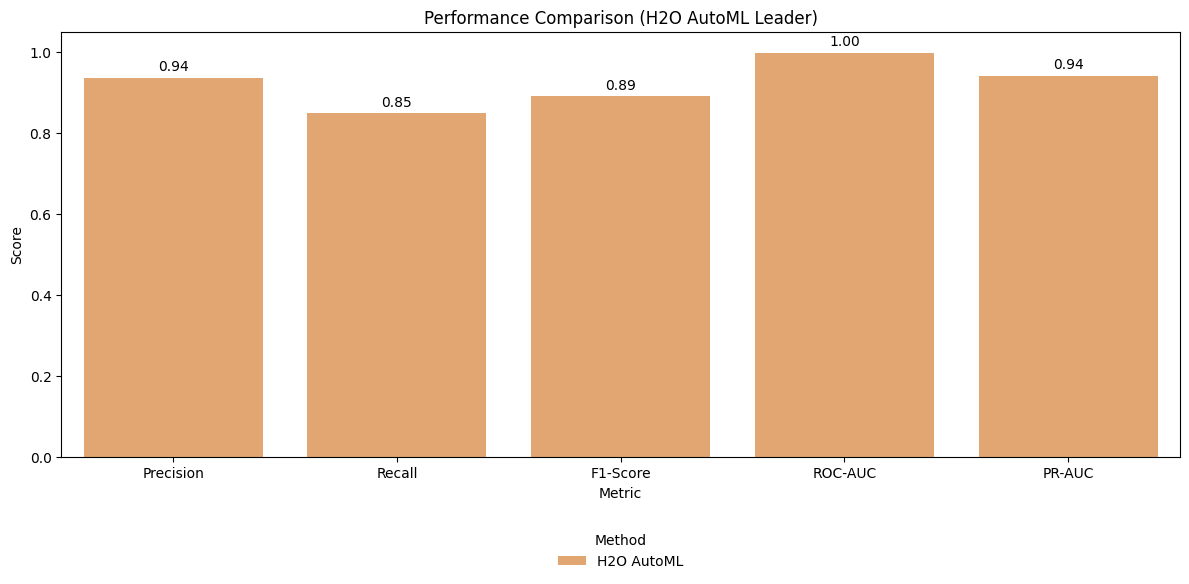

In [24]:
# --- Display Metrics Comparison ---
metrics = {
    "Method": ["H2O AutoML"],
    "Precision": [precision_score(y_true, y_pred)],
    "Recall": [recall_score(y_true, y_pred)],
    "F1-Score": [f1_score(y_true, y_pred)],
    "ROC-AUC": [roc_auc],
    "PR-AUC": [pr_auc]
}
df_metrics = pd.DataFrame(metrics)
df_melt = df_metrics.melt(id_vars="Method", var_name="Metric", value_name="Score")
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melt, x="Metric", y="Score", hue="Method", palette=["sandybrown"])
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.2f}',
            ha="center", va="bottom"
        )
plt.title("Performance Comparison (H2O AutoML Leader)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(
    title="Method",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)
plt.tight_layout()
plt.grid(False)
plt.show()

Overfitting Plot

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


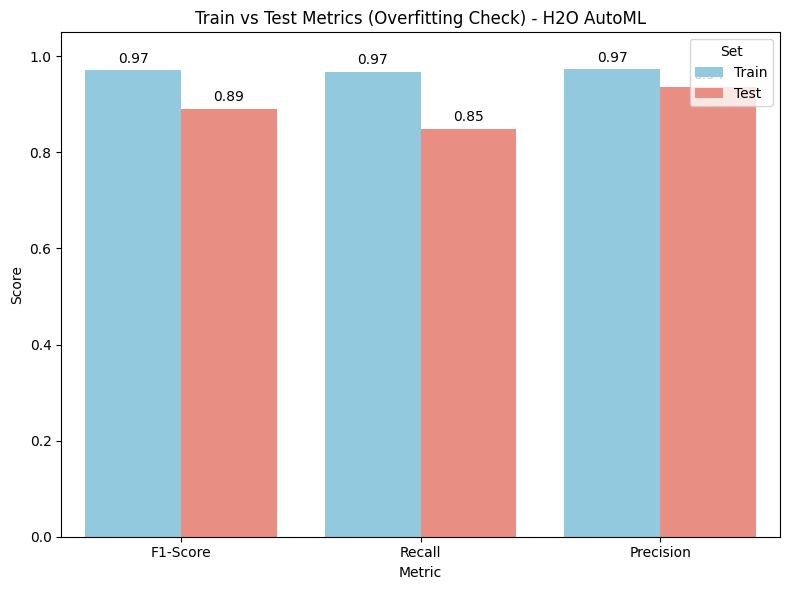

In [25]:
train_preds = aml.leader.predict(train_h2o).as_data_frame()
y_train_true = train_h2o['is_fraud'].as_data_frame().values.flatten().astype(int)
y_train_pred = train_preds['predict'].values.astype(int)
y_train_score = train_preds['p1'].values

train_f1 = f1_score(y_train_true, y_train_pred)
train_recall = recall_score(y_train_true, y_train_pred)
train_precision = precision_score(y_train_true, y_train_pred)

test_f1 = f1_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred)

df_overfit = pd.DataFrame({
    "Metric": ["F1-Score", "Recall", "Precision"],
    "Train": [train_f1, train_recall, train_precision],
    "Test": [test_f1, test_recall, test_precision]
})
df_overfit = df_overfit.melt(id_vars="Metric", var_name="Set", value_name="Score")
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_overfit, x="Metric", y="Score", hue="Set", palette=["skyblue", "salmon"])
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.2f}',
            ha="center", va="bottom"
        )
plt.title("Train vs Test Metrics (Overfitting Check) - H2O AutoML")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.tight_layout()
plt.grid(False)
plt.show()

### 2.3 Save Model

In [26]:
# Save H2O AutoML leader model
# model_path = h2o.save_model(model=aml.leader, path="h2o_leader_model", force=True)
model_path = h2o.save_model(model=aml.leader, path="/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/h2o_leader_model", force=True)
print("Model saved to:", model_path)

Model saved to: /Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/h2o_leader_model/StackedEnsemble_BestOfFamily_1_AutoML_3_20250723_224302


# Model Testing

In [27]:
# Load test data
df = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTest_cleaned.csv", index_col=0)
loaded_model = h2o.load_model("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/general_split/h2o_leader_model/StackedEnsemble_H2OAutoML_GeneralSplit")

In [28]:
# Random sample for testing
sample_df = df.sample(100).copy()

# Remove same columns as in training
columns_to_exclude = ['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num']
X_sample = sample_df.drop(columns=columns_to_exclude + ['is_fraud'], axis=1, errors='ignore')

# Convert to H2O Frame
X_sample_h2o = h2o.H2OFrame(X_sample)

print(f"Sample data shape: {X_sample_h2o.shape}")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Sample data shape: (100, 41)


In [29]:
preds = loaded_model.predict(X_sample_h2o).as_data_frame()
print(preds)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
    predict        p0        p1
0         0  0.999827  0.000173
1         0  0.999933  0.000067
2         0  0.999941  0.000059
3         0  0.999777  0.000223
4         0  0.999910  0.000090
..      ...       ...       ...
95        0  0.999947  0.000053
96        1  0.001806  0.998194
97        0  0.999863  0.000137
98        1  0.269875  0.730125
99        0  0.999926  0.000074

[100 rows x 3 columns]


In [30]:
# Add predictions and fraud probability to sample_df
sample_df['predicted_is_fraud'] = preds['predict'].values.astype(int)
sample_df['fraud_probability'] = preds['p1'].values

# Select columns to display
columns_to_show = ['trans_date_trans_time', 'trans_num', 'cc_num', 'first', 'last', 'merchant', 'amt',
                      'is_fraud', 'predicted_is_fraud', 'fraud_probability']

display(sample_df[columns_to_show].reset_index(drop=True))

,trans_date_trans_time,trans_num,cc_num,first,last,merchant,amt,is_fraud,predicted_is_fraud,fraud_probability
0,2020-10-23 03:01:57,0529d43eb84ec3a14067f0ae9e203275,3568736585751727,Thomas,Cross,20,111.61,0,0,0.000173
1,2020-07-15 04:09:34,23ee8a194d68a6b58a5e6077b401dc34,30248898834493,Michael,Rodriguez,108,10.05,0,0,0.000067
2,2020-09-04 14:09:04,7f085ce87bae0e2afa8aa04a2e4ece05,4586260469584,Melody,Thompson,450,58.09,0,0,0.000059
3,2020-08-09 13:40:11,7f1bff8f478ecf11aec3b371d8475b65,342035762534413,Jennifer,Carrillo,304,113.78,0,0,0.000223
4,2020-11-28 11:49:20,73f4873f46053d14d00cec6dce78732b,342952484382519,Kayla,Jones,99,54.52,0,0,0.000090
...,...,...,...,...,...,...,...,...,...,...
95,2020-12-06 06:35:07,a07e025df35318f2dabae1ee2f73a2ca,4384910379661778,Michelle,Russell,468,97.08,0,0,0.000053
96,2020-09-27 00:55:32,cb528601c22e106a6d27b1ac8fb48c35,372965408103277,Debbie,Robbins,570,292.10,1,1,0.998194
97,2020-08-30 22:45:26,d48e45e98e663d070f187efca7b5bd69,4939976756738216,Michelle,Johnston,141,2.93,0,0,0.000137
98,2020-12-16 22:32:15,1468ce0b7d665a8abec31eb17af90823,2714019737356678,Christina,Moore,441,9.27,1,1,0.730125
